# Age Detection Dataset

Predict the age of an Actor or Actress from facial attributes

Source: [Kaggle](https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset?select=train.csv)

---

## About Dataset

### Context

Recently, many applications from biometrics,to entertainment use the information extracted from face images that contain information about age, gender, ethnic background, and emotional state. Automatic age estimation from facial images is one of the popular and challenging tasks that have different fields of applications such as controlling the content of the watched media depending on the customer's age.
So facial feature analysis has been a topic of interest mainly due to its applicability and Deep Learning techniques are now making it possible for face analysis to be not just a dream but a reality. This simple practice dataset can get you more acquainted with application of deep learning in age detection.

### Content

Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications.

The dataset provided a total of 19906 images.The attributes of data are as follows:

* ID – Unique ID of image
* Class – Age bin of person in image

---

## 1. Import Libraries

In [22]:
# Import libraries

import numpy as np
import pandas as pd
import os

import tensorflow as tf
from keras import layers, models
import cv2 # To read photos
import pickle # To save the data
from sklearn.model_selection import train_test_split # To split the data

import matplotlib.pyplot as plt

## 2. Read and clean data

In [2]:
# Images path
path = './data/age/'
image_path = './data/age/Train/'

In [3]:
# Read csv with image information
df = pd.read_csv(f'{path}train.csv')
df.head

<bound method NDFrame.head of               ID   Class
0        377.jpg  MIDDLE
1      17814.jpg   YOUNG
2      21283.jpg  MIDDLE
3      16496.jpg   YOUNG
4       4487.jpg  MIDDLE
...          ...     ...
19901   2482.jpg  MIDDLE
19902  20085.jpg   YOUNG
19903  19663.jpg  MIDDLE
19904  10132.jpg  MIDDLE
19905   9896.jpg  MIDDLE

[19906 rows x 2 columns]>

<AxesSubplot:>

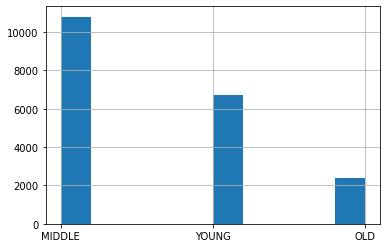

In [4]:
# Check classes
df['Class'].hist()

#### Create dummy variable for class

In [5]:
# Create numeric column for categories
# 0: Young, 1: Middle, 2: Old

classes = [0, 1, 2]

df.Class = df.Class.astype('category')
df['Category'] = df.Class.cat.codes
df

,ID,Class,Category
0,377.jpg,MIDDLE,0
1,17814.jpg,YOUNG,2
2,21283.jpg,MIDDLE,0
3,16496.jpg,YOUNG,2
4,4487.jpg,MIDDLE,0
...,...,...,...
19901,2482.jpg,MIDDLE,0
19902,20085.jpg,YOUNG,2
19903,19663.jpg,MIDDLE,0
19904,10132.jpg,MIDDLE,0


In [6]:
# Check the ids
pd.unique(df[['Class', 'Category']].values.ravel())

array(['MIDDLE', 0, 'YOUNG', 2, 'OLD', 1], dtype=object)

(65, 48)


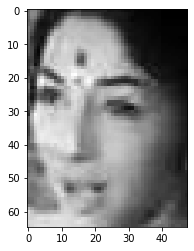

In [7]:
# Test read images
photo = cv2.imread(os.path.join(image_path, df['ID'][10]), cv2.IMREAD_GRAYSCALE)
print(photo.shape)
plt.imshow(photo, 'gray')

In [8]:
temp_resize = cv2.resize(photo,(28, 28))
type(temp_resize)

numpy.ndarray

# 3. Read photos and create dataset

In [9]:
# Read photos
def read_photo(im_path: str, IMAGE_SIZE: int):
    """
    Read photo from path and return a Numpy array of image
    :return: image_temp_resize
    """
    image_data_temp = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)                 # Read Image on gray scale
    image_temp_resize = cv2.resize(image_data_temp,(IMAGE_SIZE, IMAGE_SIZE))    # Resize photo
    return image_temp_resize

In [33]:
# Create x_data and y_data
def build_data(x_temp: list, y_temp: list, IMAGE_SIZE: int):
    X_temp = np.asanyarray(x_temp) / 255                          # Normalize data
    
    X_temp = X_temp.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    Y_temp = np.asarray(y_temp)

    return X_temp, Y_temp

In [46]:
IMAGE_SIZE = 28

In [34]:
# Read all pictures and save in variables

# Init variables to append the info
x_temp = []
y_temp = []

for index, row in df.iterrows():
    try:
        path_image = os.path.join(image_path, row['ID'])
        image_resize = read_photo(path_image, IMAGE_SIZE)
        
        x_temp.append(image_resize)
        y_temp.append(row['Category'])
        
        if index >= 1000:
            break
    except Exception as e:
        print(f"Error trying to read {row['ID']} Error {e}")
        continue

In [41]:
# Create final data in features and label

X_features, Y_labels = build_data(x_temp, y_temp, IMAGE_SIZE)

### 3.1. Save features and labels to reuse

In [42]:
pickle_out = open('X_features','wb')
pickle.dump(X_features, pickle_out)
pickle_out.close()

# Write the Y Label Data
pickle_out = open('Y_labels', 'wb')
pickle.dump(Y_labels, pickle_out)
pickle_out.close()

# 4. Create Model

In [45]:
# Get the X and Y data from pickle
X_Temp = open('X_features','rb')
X_data = pickle.load(X_Temp)
print(X_data.shape)

Y_Temp = open('Y_labels','rb')
Y_data = pickle.load(Y_Temp)
print(Y_data.shape)

(1001, 28, 28, 1)
(1001,)


In [50]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(150, (3, 3), input_shape=X_data.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(75, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5), # Disable some neurons to improve the CNN
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=32,
    validation_data=(X_test, y_test), 
    epochs=60,
    #validation_split=0.3
)

Epoch 1/60
25/25 [==============================] - 6s 236ms/step - loss: 0.9196 - accuracy: 0.5525 - val_loss: 0.8743 - val_accuracy: 0.6219
Epoch 2/60
25/25 [==============================] - 6s 225ms/step - loss: 0.9048 - accuracy: 0.5775 - val_loss: 0.8817 - val_accuracy: 0.5721
Epoch 3/60
25/25 [==============================] - 5s 216ms/step - loss: 0.8525 - accuracy: 0.6200 - val_loss: 0.8971 - val_accuracy: 0.5871
Epoch 4/60
25/25 [==============================] - 8s 329ms/step - loss: 0.8665 - accuracy: 0.5900 - val_loss: 0.8482 - val_accuracy: 0.6169
Epoch 5/60
25/25 [==============================] - 9s 362ms/step - loss: 0.8383 - accuracy: 0.6025 - val_loss: 0.8585 - val_accuracy: 0.5970
Epoch 6/60
25/25 [==============================] - 6s 242ms/step - loss: 0.8345 - accuracy: 0.6175 - val_loss: 0.8474 - val_accuracy: 0.6119
Epoch 7/60
25/25 [==============================] - 7s 262ms/step - loss: 0.8211 - accuracy: 0.6137 - val_loss: 0.8515 - val_accuracy: 0.6070
Epoch 

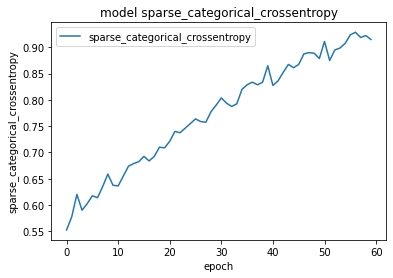

In [68]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['sparse_categorical_crossentropy'])
# plt.plot(history.history['loss'])
plt.title('model sparse_categorical_crossentropy')
plt.ylabel('sparse_categorical_crossentropy')
plt.xlabel('epoch')
plt.legend(['sparse_categorical_crossentropy', 'Loss'], loc='upper left')
plt.show()

# 5. Test model


In [61]:
image_test = X_test[0].reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
prediction = model.predict([image_test])
print(f'Test: {y_test[0]} Model: {prediction}')

1/1 [==============================] - 0s 202ms/step
Test: 2 Model: [[0.50997573 0.17073387 0.31929046]]


In [69]:
prediction = model.predict(image_test)
prediction

1/1 [==============================] - 0s 48ms/step


array([[0.952429  , 0.00539904, 0.04217189]], dtype=float32)

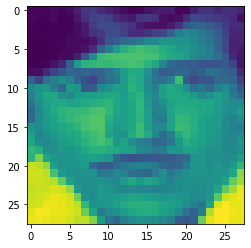

In [77]:
plt.imshow(image_test.reshape(28,28))

## 3. Read 

#### notas clase

##### Para hacerlo por CNN (convolutional Neural Network:

1. Leer Dataset
2. EDA
3. Generar más datos a partir de la data actual o eliminar y dejar todas las clases del mismo tamaño
4. Hacer una transformación para minimizar el tamañode la imagen (224x224 más o menos)
5. Montarlo a una CNN

#### Para hacerlo por transformers